In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.pytorch
import pytorch_lightning as pl
import joblib

# Importation des modules de Darts
from darts import TimeSeries
from darts.models.forecasting.tft_model import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.data import MixedCovariatesSequentialDataset
from darts.metrics import mae, rmse, mape

# Importation des callbacks PyTorch Lightning
from pytorch_lightning.callbacks import (
    TQDMProgressBar,
    EarlyStopping,
    ModelCheckpoint,
    LambdaCallback,
    Callback
)

# Importation des métriques de Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [2]:
################################
## 1 - Charger les données    ##
################################

df_original = pd.read_csv(r"..\..\..\..\Datasources\MetroPT3_new_imputed_final.csv", delimiter=",", decimal=".")

continuous_features  = ["TP2","H1","DV_pressure", "Oil_temperature", "Motor_current"]
categorical_features = ["COMP", "DV_eletric", "MPG"]

features = continuous_features + categorical_features

# Conserver uniquement les colonnes utiles
df_original = df_original[["timestamp", "panne"] + features]

# Conversion timestamp
df_original["timestamp"] = pd.to_datetime(df_original["timestamp"])
df_original = df_original.set_index("timestamp")  # Définir `timestamp` comme index

df = df_original.copy()

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")
display(df.head(2))

Utilisation de : cpu


,panne,TP2,H1,DV_pressure,Oil_temperature,Motor_current,COMP,DV_eletric,MPG
timestamp,,,,,,,,,
2020-04-12 11:20:00,0,9.128,-0.018,-0.022,55.475,6.0175,0.0,1.0,0.0
2020-04-12 11:20:10,0,9.354,-0.016,-0.020,56.525,6.0075,0.0,1.0,0.0


In [3]:
#######################################################################
## 1.1 - Miniaturiser le dataset juste pour un test d'efficacité    ##
######################################################################

#{'id': 'Panne16', 'start': '2020-06-05 10:00:00', 'end': '2020-06-05 23:59:00'},
#{'id': 'Panne17', 'start': '2020-06-06 00:00:00', 'end': '2020-06-06 23:59:00'},

start_date = "2020-06-05 09:30:00"
end_date   = "2020-06-06 02:59:00"
df = df[(df.index >= start_date) & (df.index <= end_date)]
print(f" Nombre total d'observations après filtrage : {len(df)}")

 Nombre total d'observations après filtrage : 6295


In [4]:
########################################
## 2 - Normalisation et Convérsion    ##
########################################

series_transformed = TimeSeries.from_dataframe(df, value_cols=["panne"], freq="10s", fill_missing_dates=False)

# Normalisation
scaler_continuous = Scaler()
series_continuous_transformed = scaler_continuous.fit_transform(TimeSeries.from_dataframe(df, value_cols=continuous_features))

# Covariables temporelles
covariates = datetime_attribute_timeseries(series_transformed, attribute="month", one_hot=True)
scaler_covariates = Scaler()
covariates_transformed = scaler_covariates.fit_transform(covariates)

print("Normalisation et conversion effectuées.")

Normalisation et conversion effectuées.


In [5]:
########################################
## 2.1 - Sauvegarde du Scaler         ##
########################################

# Sauvegarde du Scaler normalisé après l'entraînement
joblib.dump(scaler_continuous, rf"..\..\Generated_Files\TFT\scaler_continuous.pkl")
joblib.dump(scaler_covariates, rf"..\..\Generated_Files\TFT\scaler_covariates.pkl")
print("Scalers sauvegardés avec succès.")


Scalers sauvegardés avec succès.


In [6]:
##########################################
## 3 - Validation des normalisations    ##
##########################################

# Convertir `series_continuous_transformed` en DataFrame
df_continuous_transformed = series_continuous_transformed.pd_dataframe()

# Affichage des données avant normalisation
print("Données avant normalisation :")
display(df[continuous_features].head(2))

# Affichage des données après normalisation
print("Données après normalisation :")
display(df_continuous_transformed.head(2))


Données avant normalisation :


,TP2,H1,DV_pressure,Oil_temperature,Motor_current
timestamp,,,,,
2020-06-05 09:30:00,-0.016,8.062,-0.022,58.875,0.0425
2020-06-05 09:30:10,5.564,-0.028,-0.022,58.800,5.1775


Données après normalisation :


component,TP2,H1,DV_pressure,Oil_temperature,Motor_current
timestamp,,,,,
2020-06-05 09:30:00,0.000954,0.795008,0.00072,0.009235,0.000402
2020-06-05 09:30:10,0.533295,0.000000,0.00072,0.005277,0.825633


In [7]:
# Dataset commence le 2020-04-12 11:20:00 et se termine le 2020-07-17 06:00:00
pannes = [
    {'id': 'Panne1',  'start': '2020-04-12 11:50:00', 'end': '2020-04-12 23:30:00'},
    {'id': 'Panne2',  'start': '2020-04-18 00:00:00', 'end': '2020-04-18 23:59:00'},
    {'id': 'Panne3',  'start': '2020-04-19 00:00:00', 'end': '2020-04-19 01:30:00'},
    {'id': 'Panne4',  'start': '2020-04-29 03:20:00', 'end': '2020-04-29 04:00:00'},
    {'id': 'Panne5',  'start': '2020-04-29 22:00:00', 'end': '2020-04-29 22:20:00'},
    {'id': 'Panne6',  'start': '2020-05-13 14:00:00', 'end': '2020-05-13 23:59:00'},
    {'id': 'Panne7',  'start': '2020-05-18 05:00:00', 'end': '2020-05-18 05:30:00'},
    {'id': 'Panne8',  'start': '2020-05-19 10:10:00', 'end': '2020-05-19 11:00:00'},
    {'id': 'Panne9',  'start': '2020-05-19 22:10:00', 'end': '2020-05-19 23:59:00'},
    {'id': 'Panne10', 'start': '2020-05-20 00:00:00', 'end': '2020-05-20 20:00:00'},
    {'id': 'Panne11', 'start': '2020-05-23 09:50:00', 'end': '2020-05-23 10:10:00'},
    {'id': 'Panne12', 'start': '2020-05-29 23:30:00', 'end': '2020-05-29 23:59:00'},
    {'id': 'Panne13', 'start': '2020-05-30 00:00:00', 'end': '2020-05-30 06:00:00'},
    {'id': 'Panne14', 'start': '2020-06-01 15:00:00', 'end': '2020-06-01 15:40:00'},
    {'id': 'Panne15', 'start': '2020-06-03 10:00:00', 'end': '2020-06-03 11:00:00'},
    {'id': 'Panne16', 'start': '2020-06-05 10:00:00', 'end': '2020-06-05 23:59:00'},
    {'id': 'Panne17', 'start': '2020-06-06 00:00:00', 'end': '2020-06-06 23:59:00'},
    {'id': 'Panne18', 'start': '2020-06-07 00:00:00', 'end': '2020-06-07 14:30:00'},
    {'id': 'Panne19', 'start': '2020-07-08 17:30:00', 'end': '2020-07-08 19:00:00'},
    {'id': 'Panne20', 'start': '2020-07-15 14:30:00', 'end': '2020-07-15 19:00:00'},
    {'id': 'Panne21', 'start': '2020-07-17 04:30:00', 'end': '2020-07-17 05:30:00'}
         ]

In [8]:
##########################################
## 4 - Séparation Train/Val            ##
##########################################

print(f"Nombre total d'observations dans `series_transformed` : {series_transformed.n_samples}")


# Séparation Train/Test basée sur une date spécifique
split_date = pd.Timestamp("2020-06-05 12:30:00")

# Filtrer les données en utilisant l'index temporel de Darts
train = series_transformed.drop_after(split_date)  # Garde tout ce qui est AVANT `split_date`
val = series_transformed.drop_before(split_date - pd.Timedelta(seconds=10))  # Garde tout ce qui est APRÈS `split_date`

print(f"Taille du Train : {len(train)} observations")
print(f"Taille du Test : {len(val)} observations")

# Vérifier et ajuster `future_covariates`
future_covariates_train = covariates_transformed.slice_intersect(train)
future_covariates_val = covariates_transformed.slice_intersect(val)

print(f"Future Covariates Train : {future_covariates_train.n_samples} observations")
print(f"Future Covariates Val : {future_covariates_val.n_samples} observations")


Nombre total d'observations dans `series_transformed` : 1
Taille du Train : 1080 observations
Taille du Test : 5215 observations
Future Covariates Train : 1 observations
Future Covariates Val : 1 observations


In [9]:
print(f"Type de l'index de df : {df.index.dtype}")
print(f"Exemples d'index : {df.index[:5]}")
print(f"Nombre de valeurs uniques dans timestamp : {df.index.nunique()}")

Type de l'index de df : datetime64[ns]
Exemples d'index : DatetimeIndex(['2020-06-05 09:30:00', '2020-06-05 09:30:10',
               '2020-06-05 09:30:20', '2020-06-05 09:30:30',
               '2020-06-05 09:30:40'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
Nombre de valeurs uniques dans timestamp : 6295


In [10]:
##########################################
## 5 - Création des Fenêtres            ##
##########################################

# 120×10s=1200s=20 minutes
# 60×10s=600s=10 minutes

# Définir la taille des fenêtres
input_chunk_length = 120  # 20 minutes
output_chunk_length = 60

dataset = MixedCovariatesSequentialDataset(
    target_series=train,
    future_covariates=future_covariates_train,
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length
)

val_dataset = MixedCovariatesSequentialDataset(
    target_series=val,
    future_covariates=future_covariates_val,
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length
)

print(f"Nombre total de fenêtres Train après segmentation : {len(dataset)}")
print(f"Nombre total de fenêtres Validation après segmentation : {len(val_dataset)}")

Nombre total de fenêtres Train après segmentation : 901
Nombre total de fenêtres Validation après segmentation : 5036


In [11]:
##########################################################################################################################################
## La classe `SaveTarCheckpoint` est un callback PyTorch Lightning qui sauvegarde automatiquement les poids                             ##
## du modèle et l'état de l'optimiseur à la fin de chaque epoch sous format `.tar`. La fonction `save_full_checkpoint`                  ##
## permet de sauvegarder manuellement un modèle entier avec ses hyperparamètres après un certain nombre d'epochs.                       ##
##########################################################################################################################################

# Définition d'une classe personnalisée pour sauvegarder les checkpoints en format .tar
class SaveTarCheckpoint(pl.callbacks.Callback):
    def __init__(self, save_dir="./tft_checkpoints"):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)  # Création du répertoire s'il n'existe pas

    # Méthode appelée à la fin de chaque epoch pour sauvegarder l'état du modèle et de l'optimiseur
    def on_train_epoch_end(self, trainer, pl_module):
        epoch = trainer.current_epoch  # Récupération de l'epoch actuelle
        checkpoint_path = os.path.join(self.save_dir, f"tft_model_checkpoint_epoch_{epoch}.tar")

        # Sauvegarde des informations essentielles sous format .tar
        torch.save({
            "epoch": epoch,
            "model_state_dict": pl_module.state_dict(),  # Poids du modèle
            "optimizer_state_dict": trainer.optimizers[0].state_dict(),  # État de l'optimiseur
        }, checkpoint_path)
        
        print(f"Checkpoint sauvegardé : {checkpoint_path}")  # Affichage du chemin du fichier sauvegardé
        
# Fonction pour sauvegarder un checkpoint complet d'un modèle entraîné
def save_full_checkpoint(model, epoch):
    checkpoint_path = f"./tft_checkpoints/tft_model_checkpoint_epoch_{epoch}.tar"

    # Vérification que le modèle interne (`model.model`) existe bien
    if model.model is None:
        raise ValueError("Le modèle interne (`model.model`) est introuvable. Entraîne d'abord le modèle !")

    # Sauvegarde de l'état du modèle et de ses hyperparamètres
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.model.state_dict(),  # Poids du modèle interne
        "config": model.hparams if hasattr(model, 'hparams') else {},  # Sauvegarde des hyperparamètres s'ils existent
    }, checkpoint_path)

    print(f" Modèle sauvegardé après l'epoch {epoch} sous `{checkpoint_path}`")  # Message de confirmation


In [12]:
##########################################
## 6 - Construction du Modele           ##
##########################################

# Vérifier et créer le dossier des checkpoints si nécessaire
checkpoint_dir = "./tft_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback personnalisé pour sauvegarder en `.tar` après chaque epoch
save_tar_callback = SaveTarCheckpoint(save_dir=checkpoint_dir)

# Définition des callbacks pour EarlyStopping et Checkpoint
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,  # Dossier ou enregistrer les checkpoints
    filename="tft_model-{epoch:02d}",  # Nom du fichier checkpoint
    monitor="val_loss",  # Surveiller la perte de validation
    mode="min",          # On veut minimiser la val_loss
    save_top_k=-1,        # Sauvegarder **toutes** les epochs
    every_n_epochs=1,     # Sauvegarde après chaque epoch
    save_weights_only=False  #  Sauvegarde **TOUT**, y compris les encoders
)

# Définir la callback EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss",   # Surveiller la perte de validation
    patience=5,           # Arrêter après 5 epochs sans amélioration
    verbose=True,         # Afficher des messages lors de l'arret
    mode="min",           # Minimiser la perte (val_loss doit diminuer)
    check_on_train_epoch_end=True    # Vérifie la val_loss après chaque epoch
)


# Définir le modèle TFT avec la Progress Bar et EarlyStopping
model = TFTModel(
    input_chunk_length=input_chunk_length,   # Fenêtre d'entrée 20 min
    output_chunk_length=output_chunk_length,   # Prévision sur 60 pas
    hidden_size=32,  
    lstm_layers=2,  
    num_attention_heads=4,  
    dropout=0.2,  
    batch_size=16, 
    likelihood=QuantileRegression(),
    random_state=42,
    pl_trainer_kwargs={
        "callbacks": [TQDMProgressBar(refresh_rate=1), early_stopping, checkpoint_callback, save_tar_callback],  
        "max_epochs": 50,  # Nombre d'epochs pour l'entraînement
        "log_every_n_steps": 1,  # Afficher les logs à chaque batch
        "enable_checkpointing": True  # Activer le checkpointing pour éviter l'erreur
    }
)

print("Modèle TFT construit avec succès.")
# Prochains scénarios a tester ..Optimiser les hyperparametres  (hidden_size, num_attention_heads, etc.)
# input_chunk_length=30 veut dire  30 observations passées donc 5 minutes
#  output_chunk_length=3 veut dire 3 X 10 donc 30 secondes de prédictions pour les prochaines valeurs

# afaire dans notre cas : input_chunk_length=120 -> 20 min
# output_chunk_length=60 donc 10 prochaines minutes

Modèle TFT construit avec succès.


In [14]:
##########################################
## 7 - Entraînement du Modele           ##
##########################################
print("...Entraînement du modèle TFT avec sauvegarde après chaque epoch...")

for epoch in range(2):
    model.fit_from_dataset(
        train_dataset=dataset,
        val_dataset=val_dataset,
        trainer=None,
        verbose=True,
        epochs=1,  # Entraînement **1 epoch à la fois**
        dataloader_kwargs={
            "num_workers": 4, 
            "batch_size": 16,  
            "persistent_workers": True
        },
    )

    # Récupérer les métriques
    train_loss = model.trainer.callback_metrics.get("train_loss", None)
    val_loss = model.trainer.callback_metrics.get("val_loss", None)
    
    # Sauvegarde après chaque epoch
    save_full_checkpoint(model, epoch)
    
    # Définir le chemin de sauvegarde
    model_dir = rf"..\..\Generated_Files\TFT\tft_model_epoch_{epoch}"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "tft_model.pth")

    # Sauvegarde du modèle avec la bonne méthode de Darts
    model.save(model_path)

   # Vérifier si un run MLflow est déjà actif et le fermer
    if mlflow.active_run():
        mlflow.end_run()

    # Enregistrement des métriques et du modèle dans MLflow
    with mlflow.start_run():
        if train_loss is not None:
            mlflow.log_metric("train_loss", train_loss, step=epoch)
        if val_loss is not None:
            mlflow.log_metric("val_loss", val_loss, step=epoch)
        
        mlflow.log_artifacts(model_dir, artifact_path=f"tft_model_epoch_{epoch}")

    print(f"Modèle sauvegardé sous `{model_path}` et enregistré dans MLflow.")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 14.0 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

...Entraînement du modèle TFT avec sauvegarde après chaque epoch...


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.048
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Checkpoint sauvegardé : ./tft_checkpoints\tft_model_checkpoint_epoch_0.tar
 Modèle sauvegardé après l'epoch 0 sous `./tft_checkpoints/tft_model_checkpoint_epoch_0.tar`


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 14.0 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Modèle sauvegardé sous `..\..\Generated_Files\TFT\tft_model_epoch_0\tft_model.pth` et enregistré dans MLflow.


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.047
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Checkpoint sauvegardé : ./tft_checkpoints\tft_model_checkpoint_epoch_0.tar
 Modèle sauvegardé après l'epoch 1 sous `./tft_checkpoints/tft_model_checkpoint_epoch_1.tar`
Modèle sauvegardé sous `..\..\Generated_Files\TFT\tft_model_epoch_1\tft_model.pth` et enregistré dans MLflow.


In [ ]:
##############################################################################################################################
##############################################################################################################################
******************************************************************************************************************************
******************************************************************************************************************************    
##############################################################################################################################
##############################################################################################################################

In [50]:
##############################################################################
## 8 - Création d'un ensemble de Test de 20 mn pour simuler la production  ##
############################################################################
from darts import TimeSeries
import joblib
import pandas as pd

# Définir les features continues et les covariables temporelles
continuous_features = ["TP2", "H1", "DV_pressure", "Oil_temperature", "Motor_current"]
categorical_features = ["COMP", "DV_eletric", "MPG"]

# Définir la durée nécessaire pour l'entrée du modèle (20 minutes)
test_duration = pd.Timedelta(minutes=20)

# Déterminer la plage de test
test_end = pd.Timestamp("2020-07-15 19:30:00")  # Fin de la période de test
test_start = test_end - test_duration  # Début = Fin - 20 minutes

# Filtrer `df_original` pour obtenir exactement 20 minutes de données
df_prod = df_original.loc[(df_original.index > test_start) & (df_original.index <= test_end)].copy()

# Vérifier la taille et la continuité des données
expected_size = 20 * 60 / 10  # 20 minutes * 60 secondes / 10 secondes par pas
actual_size = len(df_prod)

print(f"Taille réelle de `df_test_20min` : {actual_size} observations")
print(f"Taille attendue : {expected_size} observations")

# Supprimer la colonne `panne` (cette info n'est pas dispo en prod)
df_prod = df_prod.drop(columns=["panne"], errors="ignore")

# 📌 **Charger les scalers sauvegardés**
scaler_continuous = joblib.load(rf"..\..\Generated_Files\TFT\scaler_continuous.pkl")
scaler_covariates = joblib.load(rf"..\..\Generated_Files\TFT\scaler_covariates.pkl")

# 📌 **Séparer les features continues et les covariables**
df_prod_continuous = df_prod[continuous_features]  # Features continues
df_prod_covariates = df_prod[categorical_features]  # Covariables temporelles

# 📌 **Convertir en TimeSeries**
series_prod_continuous = TimeSeries.from_dataframe(df_prod_continuous)
series_prod_covariates = TimeSeries.from_dataframe(df_prod_covariates)

# 📌 **Appliquer les scalers aux séries temporelles**
df_prod_continuous_scaled = scaler_continuous.transform(series_prod_continuous)
df_prod_covariates_scaled = scaler_covariates.transform(series_prod_covariates)

# 📌 **Recombiner les données normalisées**
df_prod_scaled = df_prod_continuous_scaled.stack(df_prod_covariates_scaled)

# ✅ **Vérifier la taille après normalisation**
print(f"Taille finale après normalisation : {df_prod_scaled.shape}")

# 📌 **Convertir en série temporelle pour le modèle**
series_prod_scaled = TimeSeries.from_dataframe(df_prod_scaled)

print("✅ Données de production normalisées avec succès et converties en `TimeSeries` !")

# Vous pouvez maintenant utiliser `series_prod_scaled` pour faire des prédictions avec le modèle


Taille réelle de `df_test_20min` : 120 observations
Taille attendue : 120.0 observations


ValueError: X has 3 features, but MinMaxScaler is expecting 12 features as input.

In [26]:
########################################################################################################
########################################################################################################
########################################################################################################

Période de test construite avec 360 observations.
Nombre total de fenêtres Test : 181


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

Prédictions générées avec succès !


component,panne
time,
2020-07-15 14:59:50,0.982332
2020-07-15 15:00:00,1.015188


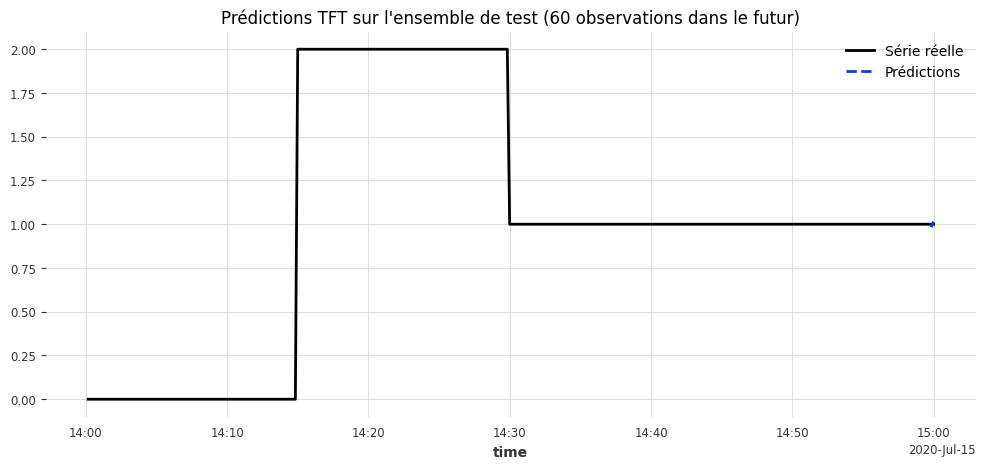

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Définir les features continues et les covariables temporelles
continuous_features = ["TP2", "H1", "DV_pressure", "Oil_temperature", "Motor_current"]
categorical_features = ["COMP", "DV_eletric", "MPG"]

# Définir la durée nécessaire pour l'entrée du modèle (60 minutes)
test_duration = pd.Timedelta(minutes=60)  # 60 minutes pour la période de test

# Définir le point de départ du test (ici, à partir de 19h30)
test_start = pd.Timestamp("2020-07-15 14:00:00")
test_end = test_start + test_duration  # La période de test s'étend sur 60 minutes

# Filtrer df_original pour obtenir exactement 60 minutes de données
df_prod = df_original.loc[(df_original.index > test_start) & (df_original.index <= test_end)].copy()

# Vérifier que la période de test contient bien les données attendues
assert len(df_prod) == test_duration.total_seconds() / 10, f"Erreur : df_prod contient {len(df_prod)} observations au lieu de {test_duration.total_seconds() / 10}"

print(f"Période de test construite avec {len(df_prod)} observations.")

# 2. Convertir en TimeSeries
series_transformed_test_prod = TimeSeries.from_dataframe(df_prod, value_cols=["panne"], freq="10s", fill_missing_dates=False)

# 3. Normalisation avec les mêmes scalers
series_continuous_transformed_test_prod = scaler_continuous.transform(
    TimeSeries.from_dataframe(df_prod, value_cols=continuous_features)
)

# Covariables temporelles (ajout du mois en one-hot encoding)
covariates_test_prod = datetime_attribute_timeseries(series_transformed_test_prod, attribute="month", one_hot=True)

# Normalisation des covariables temporelles avec le même scaler que l'entraînement
covariates_transformed_test_prod = scaler_covariates.transform(covariates_test_prod)

# 4. Créer la fenêtre de test avec 120 observations pour la prédiction
input_chunk_length_test_prod = 120
output_chunk_length_test_prod = 60  # 60 observations pour la sortie

# Vérifier que les covariables sont bien alignées avec la série
future_covariates_test_prod = covariates_transformed_test_prod.slice_intersect(series_transformed_test_prod)

# Créer le dataset de test
test_dataset_single_window_prod = MixedCovariatesSequentialDataset(
    target_series=series_transformed_test_prod,  
    future_covariates=future_covariates_test_prod,  
    input_chunk_length=input_chunk_length_test_prod,
    output_chunk_length=output_chunk_length_test_prod
)

# Afficher le nombre de fenêtres
print(f"Nombre total de fenêtres Test : {len(test_dataset_single_window_prod)}")

# 5. Effectuer la prédiction sur cette fenêtre unique
extended_predictions_prod = model.historical_forecasts(
    series=series_transformed_test_prod,  
    future_covariates=future_covariates_test_prod,  
    start=series_transformed_test_prod.end_time() - pd.Timedelta(seconds=10 * output_chunk_length_test_prod),
    forecast_horizon=output_chunk_length_test_prod,  # 60 observations pour la sortie
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

# 6. Affichage des prédictions
print("Prédictions générées avec succès !")
display(extended_predictions_prod.pd_dataframe().head(20))  # Afficher les 20 premières valeurs

# Visualisation
plt.figure(figsize=(12, 5))
series_transformed_test_prod.plot(label="Série réelle")
extended_predictions_prod.plot(label="Prédictions", linestyle="dashed")
plt.title("Prédictions TFT sur l'ensemble de test (60 observations dans le futur)")
plt.legend()
plt.show()


Nombre total de prédictions entre 2020-07-15 14:00:00 et 2020-07-17 05:30:00 : 2


component,panne
time,
2020-07-15 14:59:50,0.982332
2020-07-15 15:00:00,1.015188


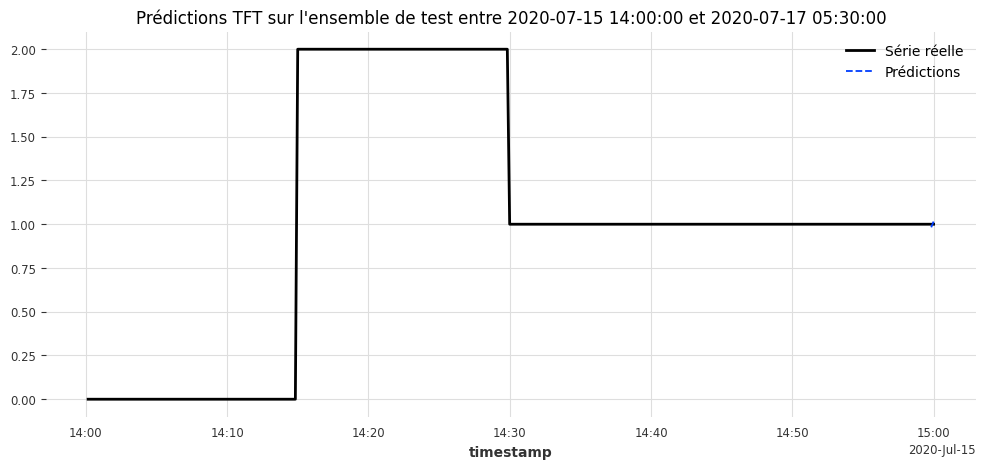

In [68]:
# Définir la période de test
test_start = pd.Timestamp("2020-07-15 14:00:00")
test_end = pd.Timestamp("2020-07-17 05:30:00")

# Vérification de la durée totale des prédictions générées
extended_predictions_prod_df = extended_predictions_prod.pd_dataframe()

# Filtrer les prédictions dans la période de test spécifiée
filtered_predictions = extended_predictions_prod_df[
    (extended_predictions_prod_df.index >= test_start) & 
    (extended_predictions_prod_df.index <= test_end)
]

# Affichage des prédictions entre test_start et test_end
print(f"Nombre total de prédictions entre {test_start} et {test_end} : {len(filtered_predictions)}")
display(filtered_predictions)

# Visualisation des prédictions entre test_start et test_end
plt.figure(figsize=(12, 5))
series_transformed_test_prod.plot(label="Série réelle")  # Afficher la série réelle
plt.plot(filtered_predictions.index, filtered_predictions["panne"], label="Prédictions", linestyle="dashed")
plt.title(f"Prédictions TFT sur l'ensemble de test entre {test_start} et {test_end}")
plt.legend()
plt.show()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

Nombre total de prédictions générées entre 2020-07-15 14:00:00 et 2020-07-17 05:30:00 : 78


component,panne
time,
2020-07-15 14:59:40,1.004844
2020-07-15 14:59:50,1.002405
2020-07-15 15:59:40,1.855792
2020-07-15 15:59:50,1.001359
2020-07-15 16:59:40,1.018681
...,...
2020-07-17 02:59:50,1.008230
2020-07-17 03:59:40,0.981659
2020-07-17 03:59:50,1.001720


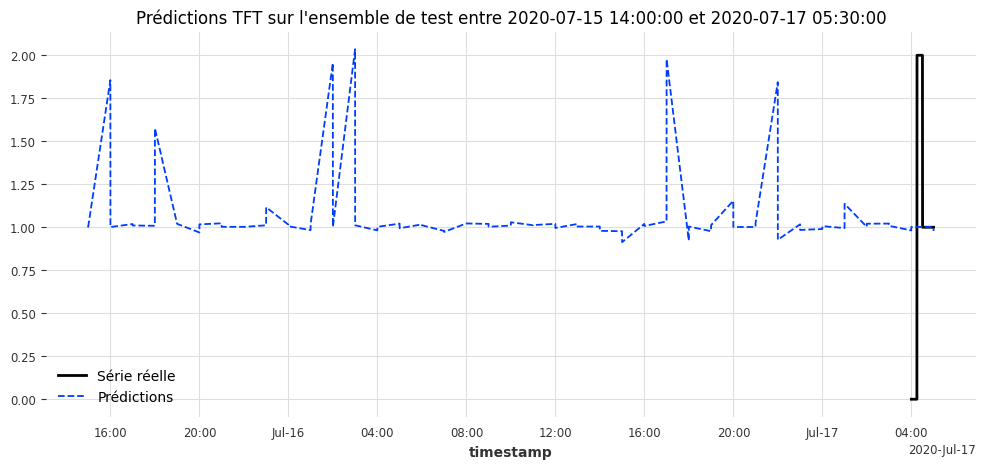

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Définir la période de test
test_start = pd.Timestamp("2020-07-15 14:00:00")
test_end = pd.Timestamp("2020-07-17 05:30:00")

# Durée de la période de prédiction
prediction_duration = pd.Timedelta(minutes=60)  # Durée de chaque prédiction (60 minutes)

# Liste pour stocker toutes les prédictions
all_predictions = []

# Effectuer des prédictions sur des fenêtres successives
current_start = test_start

while current_start < test_end:
    # Définir la période de test actuelle (fenêtre glissante)
    current_end = current_start + prediction_duration
    if current_end > test_end:
        break  # Arrêter si la période dépasse la fin de l'intervalle

    # Filtrer les données pour cette fenêtre de temps
    df_prod_window = df_original.loc[(df_original.index >= current_start) & (df_original.index < current_end)].copy()

    # Convertir en TimeSeries
    series_transformed_test_prod = TimeSeries.from_dataframe(df_prod_window, value_cols=["panne"], freq="10s", fill_missing_dates=False)

    # Normalisation avec les mêmes scalers
    series_continuous_transformed_test_prod = scaler_continuous.transform(
        TimeSeries.from_dataframe(df_prod_window, value_cols=continuous_features)
    )

    # Covariables temporelles (ajout du mois en one-hot encoding)
    covariates_test_prod = datetime_attribute_timeseries(series_transformed_test_prod, attribute="month", one_hot=True)

    # Normalisation des covariables temporelles avec le même scaler que l'entraînement
    covariates_transformed_test_prod = scaler_covariates.transform(covariates_test_prod)

    # Créer la fenêtre de test pour cette période
    future_covariates_test_prod = covariates_transformed_test_prod.slice_intersect(series_transformed_test_prod)

    # Créer le dataset de test
    test_dataset_single_window_prod = MixedCovariatesSequentialDataset(
        target_series=series_transformed_test_prod,  
        future_covariates=future_covariates_test_prod,  
        input_chunk_length=120,
        output_chunk_length=60
    )

    # Effectuer la prédiction pour cette fenêtre
    extended_predictions_prod = model.historical_forecasts(
        series=series_transformed_test_prod,
        future_covariates=future_covariates_test_prod,
        start=series_transformed_test_prod.end_time() - pd.Timedelta(seconds=10 * 60),  # Prédiction sur 60 observations
        forecast_horizon=60,
        stride=1,
        retrain=False,
        overlap_end=True,
        verbose=True
    )

    # Ajouter les prédictions à la liste
    all_predictions.append(extended_predictions_prod.pd_dataframe())

    # Avancer dans le temps pour la prochaine fenêtre
    current_start = current_end

# Combiner toutes les prédictions dans un seul DataFrame
all_predictions_df = pd.concat(all_predictions)

# Filtrer les prédictions entre test_start et test_end
filtered_predictions = all_predictions_df[
    (all_predictions_df.index >= test_start) & 
    (all_predictions_df.index <= test_end)
]

# Afficher les prédictions
print(f"Nombre total de prédictions générées entre {test_start} et {test_end} : {len(filtered_predictions)}")
display(filtered_predictions)

# Visualisation des prédictions entre test_start et test_end
plt.figure(figsize=(12, 5))
series_transformed_test_prod.plot(label="Série réelle")  # Afficher la série réelle
plt.plot(filtered_predictions.index, filtered_predictions["panne"], label="Prédictions", linestyle="dashed")
plt.title(f"Prédictions TFT sur l'ensemble de test entre {test_start} et {test_end}")
plt.legend()
plt.show()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

Nombre total de prédictions générées entre 2020-07-15 14:00:00 et 2020-07-17 05:30:00 : 79


component,panne
time,
2020-07-15 14:29:50,1.023814
2020-07-15 14:59:50,1.003753
2020-07-15 15:29:50,1.004045
2020-07-15 15:59:50,1.019302
2020-07-15 16:29:50,1.020966
...,...
2020-07-17 03:29:50,0.938732
2020-07-17 03:59:50,1.019130
2020-07-17 04:29:50,1.019428


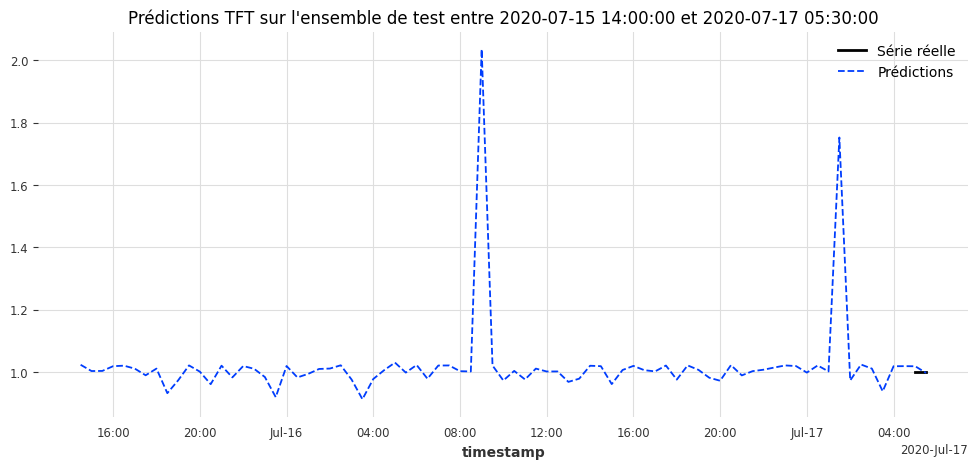

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Définir la période de test
test_start = pd.Timestamp("2020-07-15 14:00:00")
test_end = pd.Timestamp("2020-07-17 05:30:00")

# Durée de la période de prédiction (20 minutes pour chaque prédiction)
prediction_duration = pd.Timedelta(minutes=30)  # Durée de chaque prédiction (20 minutes)

# Liste pour stocker toutes les prédictions
all_predictions = []

# Effectuer des prédictions sur des fenêtres successives toutes les 20 minutes
current_start = test_start

while current_start < test_end:
    # Définir la période de test actuelle (fenêtre glissante de 20 minutes)
    current_end = current_start + prediction_duration
    if current_end > test_end:
        break  # Arrêter si la période dépasse la fin de l'intervalle

    # Filtrer les données pour cette fenêtre de temps
    df_prod_window = df_original.loc[(df_original.index >= current_start) & (df_original.index < current_end)].copy()

    # Vérifier si la fenêtre contient assez de données pour la prédiction
    if len(df_prod_window) < 180:  # 180 observations requises pour input_chunk + output_chunk
        print(f"Fenêtre trop petite pour la prédiction entre {current_start} et {current_end}. Sauter cette fenêtre.")
        current_start = current_end
        continue  # Passer à la fenêtre suivante

    # Convertir en TimeSeries
    series_transformed_test_prod = TimeSeries.from_dataframe(df_prod_window, value_cols=["panne"], freq="10s", fill_missing_dates=False)

    # Normalisation avec les mêmes scalers
    series_continuous_transformed_test_prod = scaler_continuous.transform(
        TimeSeries.from_dataframe(df_prod_window, value_cols=continuous_features)
    )

    # Covariables temporelles (ajout du mois en one-hot encoding)
    covariates_test_prod = datetime_attribute_timeseries(series_transformed_test_prod, attribute="month", one_hot=True)

    # Normalisation des covariables temporelles avec le même scaler que l'entraînement
    covariates_transformed_test_prod = scaler_covariates.transform(covariates_test_prod)

    # Vérifier l'alignement des indices de temps entre la série et les covariables
    future_covariates_test_prod = covariates_transformed_test_prod.slice_intersect(series_transformed_test_prod)

    # Créer le dataset de test
    test_dataset_single_window_prod = MixedCovariatesSequentialDataset(
        target_series=series_transformed_test_prod,  
        future_covariates=future_covariates_test_prod,  
        input_chunk_length=120,  # 120 observations pour la fenêtre d'entrée
        output_chunk_length=60   # 60 observations pour la sortie
    )

    # Effectuer la prédiction pour cette fenêtre
    extended_predictions_prod = model.historical_forecasts(
        series=series_transformed_test_prod,
        future_covariates=future_covariates_test_prod,
        start=series_transformed_test_prod.end_time() - pd.Timedelta(seconds=10 * 60),  # Prédiction sur 60 observations
        forecast_horizon=60,
        stride=1,  # stride de 1 pour des prédictions plus fréquentes
        retrain=False,
        overlap_end=True,  # Permet d'obtenir des prédictions continues
        verbose=True
    )

    # Ajouter les prédictions à la liste
    all_predictions.append(extended_predictions_prod.pd_dataframe())

    # Avancer dans le temps pour la prochaine fenêtre (20 minutes)
    current_start = current_end

# Combiner toutes les prédictions dans un seul DataFrame
all_predictions_df = pd.concat(all_predictions)

# Filtrer les prédictions entre test_start et test_end
filtered_predictions = all_predictions_df[
    (all_predictions_df.index >= test_start) & 
    (all_predictions_df.index <= test_end)
]

# Afficher les prédictions
print(f"Nombre total de prédictions générées entre {test_start} et {test_end} : {len(filtered_predictions)}")
display(filtered_predictions)

# Visualisation des prédictions entre test_start et test_end
plt.figure(figsize=(12, 5))
series_transformed_test_prod.plot(label="Série réelle")  # Afficher la série réelle
plt.plot(filtered_predictions.index, filtered_predictions["panne"], label="Prédictions", linestyle="dashed")  # Afficher les prédictions
plt.title(f"Prédictions TFT sur l'ensemble de test entre {test_start} et {test_end}")
plt.legend()
plt.show()


In [27]:
########################################################################################################
########################################################################################################
########################################################################################################

In [ ]:
########################################################################################################
## 8 - Prédiction a partir du Modele construit et qui se situe dans la memoire par celui de chargé   ##
#######################################################################################################

In [76]:
##########################################
## 8 - Création de l'ensemble de Test   ##
##########################################

# Définition des features utilisées
continuous_features  = ["TP2", "H1", "DV_pressure", "Oil_temperature", "Motor_current"]
categorical_features = ["COMP", "DV_eletric", "MPG"]

# Définir la plage de test sur 120 minutes
new_test_start = pd.Timestamp("2020-07-15 13:30:00")  
new_test_end   = new_test_start + pd.Timedelta(minutes=120)  # 120 minutes (2 heures)

# Filtrer `df_test` pour garantir exactement 720 observations
df_test = df_original.loc[(df_original.index >= new_test_start) & (df_original.index < new_test_end)].copy()

# Vérifier que l'ensemble de test contient bien 720 observations
assert len(df_test) == 720, f"Erreur : df_test contient {len(df_test)} observations au lieu de 720"

print(f"Ensemble de test bien construit avec {len(df_test)} observations (120 minutes).")


Ensemble de test bien construit avec 720 observations (120 minutes).


In [77]:
################################################################
## 9 - Normalisation et Conversion de l'ensemble de Test      ##
################################################################

# Convertir les labels en `TimeSeries`
series_transformed_test = TimeSeries.from_dataframe(df_test, value_cols=["panne"], freq="10s", fill_missing_dates=False)
Test = series_transformed_test  # Pour garder la même nomenclature (Train, Val et Test)

# Normalisation avec le même scaler que l'entraînement
series_continuous_transformed_test = scaler_continuous.transform(
    TimeSeries.from_dataframe(df_test, value_cols=continuous_features)
)

# Covariables temporelles (ajout du mois en one-hot encoding)
covariates_test = datetime_attribute_timeseries(series_transformed_test, attribute="month", one_hot=True)

# Normalisation des covariables temporelles avec le même scaler que l'entraînement
covariates_transformed_test = scaler_covariates.transform(covariates_test)

print("Normalisation et conversion de l'ensemble de TEST effectuées.")

Normalisation et conversion de l'ensemble de TEST effectuées.


In [78]:
#################################################################
## 10 - Validation des normalisations de l'ensemble de Test   ##
#################################################################

# Convertir `series_continuous_transformed_test` en DataFrame
df_continuous_transformed_test = series_continuous_transformed_test.pd_dataframe()

# Affichage des données avant normalisation
print("Données avant normalisation :")
display(df_test[continuous_features].head(2))

# Affichage des données après normalisation
print("Données après normalisation :")
display(df_continuous_transformed_test.head(2))

Données avant normalisation :


,TP2,H1,DV_pressure,Oil_temperature,Motor_current
timestamp,,,,,
2020-07-15 13:30:00,9.944,-0.006,-0.01,78.375,5.8925
2020-07-15 13:30:10,8.894,-0.006,-0.01,78.500,5.6700


Données après normalisation :


component,TP2,H1,DV_pressure,Oil_temperature,Motor_current
timestamp,,,,,
2020-07-15 13:30:00,0.951154,0.002162,0.00504,1.038259,0.940538
2020-07-15 13:30:10,0.850983,0.002162,0.00504,1.044855,0.904781


In [79]:
##########################################
## 11 - Création des Fenêtres de Test   ##
##########################################

# Définir la taille des fenêtres pour le test
input_chunk_length_test  = 120
output_chunk_length_test = 60

# Vérifier que les covariables de test sont bien alignées avec la plage temporelle
future_covariates_test = covariates_transformed_test.slice_intersect(series_transformed_test)

# Création du dataset de test
test_dataset = MixedCovariatesSequentialDataset(
    target_series=Test,   
    future_covariates=future_covariates_test,  
    input_chunk_length=input_chunk_length_test,
    output_chunk_length=output_chunk_length_test
)

print(f"Nombre total de fenêtres Test après segmentation : {len(test_dataset)}")


Nombre total de fenêtres Test après segmentation : 541


In [80]:
print(f"Taille réelle de `df_test` : {len(df_test)} observations")
print(f"Taille minimale requise pour avoir plusieurs fenêtres : {input_chunk_length_test + output_chunk_length_test} observations")


Taille réelle de `df_test` : 720 observations
Taille minimale requise pour avoir plusieurs fenêtres : 180 observations


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Les covariables futures ont été étendues jusqu'à 2020-07-15 15:49:50.


Predicting: |                                                                                    | 0/? [00:00<…

Prédictions générées avec succès !


component,panne
time,
2020-07-15 15:29:40,1.006691
2020-07-15 15:29:50,1.017785
2020-07-15 15:30:00,1.017664
2020-07-15 15:30:10,1.013110
2020-07-15 15:30:20,1.010653
2020-07-15 15:30:30,1.004613
2020-07-15 15:30:40,1.003949
2020-07-15 15:30:50,1.009753
2020-07-15 15:31:00,1.976666


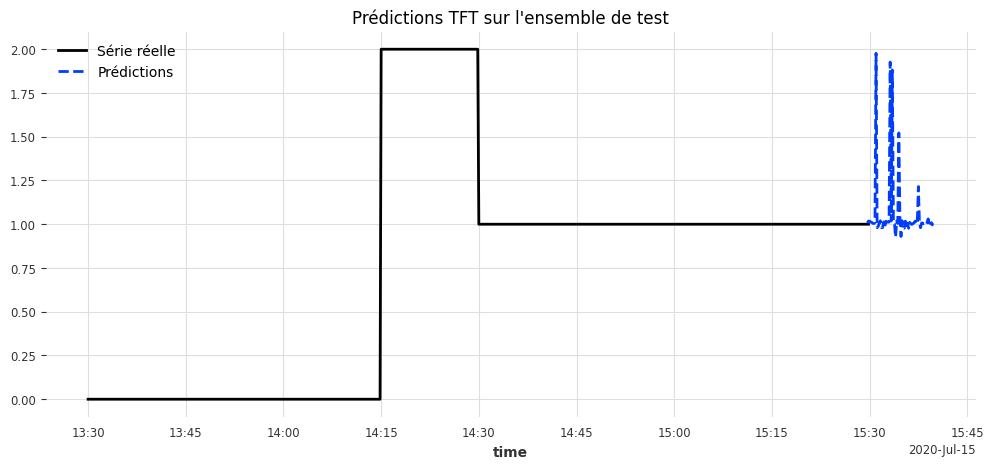

In [81]:
##########################################
## 8 - Prédictions sur l'ensemble Test  ##
##########################################

from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Vérifier la dernière date des covariables futures actuelles
last_timestamp = future_covariates_test.end_time()

# Générer de nouvelles dates futures pour couvrir toute la prédiction
new_future_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(seconds=10),  
    periods=output_chunk_length_test + 60,  
    freq="10s"  # Remplace "S" par "s" pour éviter le warning
)

# Générer les futures covariables temporelles
new_future_covariates = datetime_attribute_timeseries(
    TimeSeries.from_times_and_values(new_future_dates, np.zeros((len(new_future_dates), future_covariates_test.width))),
    attribute="month",
    one_hot=True
)

# Étendre les covariables futures
future_covariates_test_extended = future_covariates_test.append(new_future_covariates)
print(f"Les covariables futures ont été étendues jusqu'à {future_covariates_test_extended.end_time()}.")

# Vérifier que les covariables couvrent toute la période de test
assert future_covariates_test_extended.end_time() >= series_transformed_test.end_time() + pd.Timedelta(seconds=10 * output_chunk_length_test)

# **Prédiction en boucle avec `overlap_end=True` pour éviter les erreurs**
extended_predictions = model.historical_forecasts(
    series=series_transformed_test,  
    future_covariates=future_covariates_test_extended,  
    start=series_transformed_test.end_time() - pd.Timedelta(seconds=10 * output_chunk_length_test),  # Ajuster le début
    forecast_horizon=output_chunk_length_test,  # 10 minutes à la fois
    stride=1,  # 🔥 Permet de prédire chaque pas de temps
    retrain=False,  
    overlap_end=True,   # Permet de faire des prédictions jusqu’à la fin de la série
    verbose=True
)

# Affichage des prédictions
print("Prédictions générées avec succès !")
display(extended_predictions.pd_dataframe().head(20))  # Afficher les 20 premières valeurs


# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
series_transformed_test.plot(label="Série réelle")
extended_predictions.plot(label="Prédictions", linestyle="dashed")
plt.title("Prédictions TFT sur l'ensemble de test")
plt.legend()
plt.show()

In [82]:
print(f"Plage de la série test : {series_transformed_test.start_time()} → {series_transformed_test.end_time()}")
print(f"Plage des covariables futures : {future_covariates_test_extended.start_time()} → {future_covariates_test_extended.end_time()}")

Plage de la série test : 2020-07-15 13:30:00 → 2020-07-15 15:29:50
Plage des covariables futures : 2020-07-15 13:30:00 → 2020-07-15 15:49:50


In [84]:
# Vérifions la structure des prédictions
display(extended_predictions.pd_dataframe())
# On a 100 samples (num_samples=100 )
# modèle produit 100 prédictions par pas de temps
# C'est lié à l'option num_samples=100, qui indique au modèle d'utiliser une approche probabiliste (quantile regression).
# Au lieu de donner une seule valeur prédite, il génère 100 échantillons pour approximer la distribution de la variable cible.

component,panne
time,
2020-07-15 15:29:40,1.006691
2020-07-15 15:29:50,1.017785
2020-07-15 15:30:00,1.017664
2020-07-15 15:30:10,1.013110
2020-07-15 15:30:20,1.010653
...,...
2020-07-15 15:39:10,0.994959
2020-07-15 15:39:20,0.986341
2020-07-15 15:39:30,1.009196


Le modèle prédit la classe panne : [1 2]


C:\Users\usermine\Amine-Jupiter\SESSION6\ProjetSynthese\Modele1_Classification\TFT\tft_env\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


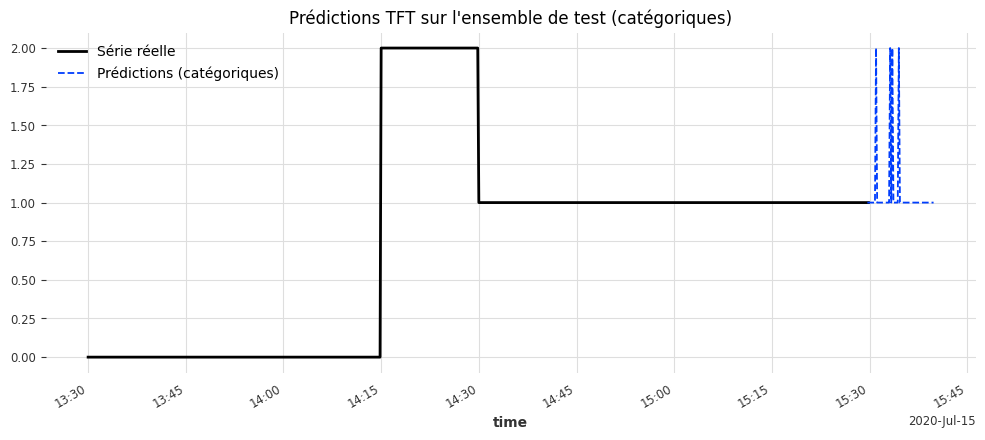

In [85]:
# Transformer les prédictions en DataFrame Pandas
predictions_df = extended_predictions.pd_dataframe()

# 🔄 Prendre la moyenne des 100 échantillons et arrondir aux classes {0,1,2}
predicted_classes = predictions_df.mean(axis=1).round().clip(0, 2).astype(int)

# Ajouter la colonne `panne` avec les classes corrigées
predictions_df["panne"] = predicted_classes

# Vérifier les valeurs obtenues
print("Le modèle prédit la classe panne :", predictions_df["panne"].unique())

# Visualisation des prédictions corrigées
plt.figure(figsize=(12, 5))
series_transformed_test.plot(label="Série réelle")
predictions_df["panne"].plot(label="Prédictions (catégoriques)", linestyle="dashed")
plt.title("Prédictions TFT sur l'ensemble de test (catégoriques)")
plt.legend()
plt.show()


In [86]:
# Convertir les prédictions en DataFrame
predictions_df = extended_predictions.pd_dataframe()

# Afficher les 100 échantillons de prédiction pour chaque timestamp
print(f"Affichage des 100 échantillons de prédictions de panne pour les premières lignes :")
display(predictions_df.head(10))  # Affiche les 10 premiers timestamps avec leurs 100 échantillons

# Vous pouvez également afficher toutes les prédictions pour un timestamp spécifique
timestamp_example = predictions_df.index[0]  # Choisir un timestamp à afficher, par exemple le premier
print(f"Les 100 échantillons de panne pour le timestamp {timestamp_example} :")
print(predictions_df.loc[timestamp_example])

# Si vous souhaitez explorer un autre timestamp, vous pouvez simplement changer l'index
timestamp_example = predictions_df.index[5]  # Par exemple, pour le 6ème timestamp
print(f"Les 100 échantillons de panne pour le timestamp {timestamp_example} :")
print(predictions_df.loc[timestamp_example])

# Vous pouvez également explorer tous les 100 échantillons pour chaque timestamp dans une boucle
for timestamp in predictions_df.index[:5]:  # Affichage des 5 premiers timestamps avec leurs 100 échantillons
    print(f"Les 100 échantillons de panne pour {timestamp}:")
    print(predictions_df.loc[timestamp])
    print("\n" + "-"*50 + "\n")


Affichage des 100 échantillons de prédictions de panne pour les premières lignes :


component,panne
time,
2020-07-15 15:29:40,1.006691
2020-07-15 15:29:50,1.017785
2020-07-15 15:30:00,1.017664
2020-07-15 15:30:10,1.013110
2020-07-15 15:30:20,1.010653
2020-07-15 15:30:30,1.004613
2020-07-15 15:30:40,1.003949
2020-07-15 15:30:50,1.009753
2020-07-15 15:31:00,1.976666


Les 100 échantillons de panne pour le timestamp 2020-07-15 15:29:40 :
component
panne    1.006691
Name: 2020-07-15 15:29:40, dtype: float64
Les 100 échantillons de panne pour le timestamp 2020-07-15 15:30:30 :
component
panne    1.004613
Name: 2020-07-15 15:30:30, dtype: float64
Les 100 échantillons de panne pour 2020-07-15 15:29:40:
component
panne    1.006691
Name: 2020-07-15 15:29:40, dtype: float64

--------------------------------------------------

Les 100 échantillons de panne pour 2020-07-15 15:29:50:
component
panne    1.017785
Name: 2020-07-15 15:29:50, dtype: float64

--------------------------------------------------

Les 100 échantillons de panne pour 2020-07-15 15:30:00:
component
panne    1.017664
Name: 2020-07-15 15:30:00, dtype: float64

--------------------------------------------------

Les 100 échantillons de panne pour 2020-07-15 15:30:10:
component
panne    1.01311
Name: 2020-07-15 15:30:10, dtype: float64

--------------------------------------------------

Les 1

In [ ]:
##########################################
## 12 - Chargement du Modele            ##
##########################################

# Autoriser les classes utilisées dans le modèle
torch.serialization.add_safe_globals([QuantileRegression])

# Définir l'epoch et le chemin du modèle
epoch = 4  # Remplace par l'epoch voulu
model_path = rf"..\..\Generated_Files\TFT\tft_model_epoch_{epoch}\tft_model.pth"

# Charger le modèle en désactivant `weights_only`
model = torch.load(model_path, weights_only=False)
print("Modèle chargé avec succès !")

In [ ]:
import torch
from darts.models.forecasting.tft_model import TFTModel
from darts.utils.likelihood_models import QuantileRegression

# Charger le fichier `.ckpt`
checkpoint_path = r"..\..\Generated_Files\TFT\tft_model_epoch_4\tft_model.pth.ckpt"

# Charger le checkpoint avec PyTorch
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Extraire les hyperparamètres
hparams = checkpoint["hyper_parameters"]

# Supprimer les hyperparamètres invalides
invalid_keys = ["output_dim", "variables_meta", "num_static_components"]
for key in invalid_keys:
    hparams.pop(key, None)  # Supprime la clé si elle existe

# Recréer un modèle TFT avec les hyperparamètres filtrés
model = TFTModel(**hparams)

# Charger les poids du modèle depuis le checkpoint
model.load_state_dict(checkpoint["state_dict"])

print("Modèle TFT chargé avec succès depuis `.ckpt` après filtrage des hyperparamètres incorrects !")


In [ ]:
checkpoint_tar = r"..\..\Modele1_Classification\TFT\tft_checkpoints\tft_model_checkpoint_epoch_4.tar"

try:
    model = torch.load(checkpoint_tar, map_location="cpu")
    print("Checkpoint chargé avec `torch.load()`")
except Exception as e:
    print(f"Erreur avec le fichier `.tar` : {e}")


In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

############################################
## 13 - Étendre les Covariables Futures  ##
############################################

# Nombre de pas supplémentaires nécessaires (60 pas = 10 minutes)
n_extra_steps = output_chunk_length_test  

# Trouver la dernière date des covariables futures actuelles
last_timestamp = future_covariates_test.end_time()

# Générer de nouvelles dates futures (10 secondes d'intervalle)
new_future_dates = pd.date_range(
    start=last_timestamp + pd.Timedelta(seconds=10),
    periods=n_extra_steps,
    freq="10S"
)

# Générer les nouvelles covariables temporelles pour ces nouvelles dates
new_future_covariates = datetime_attribute_timeseries(
    TimeSeries.from_times_and_values(new_future_dates, np.zeros((n_extra_steps, future_covariates_test.width))),
    attribute="month",
    one_hot=True
)

# Concaténer les anciennes et nouvelles covariables futures
future_covariates_test_extended = future_covariates_test.append(new_future_covariates)

############################################
## 14 - Prédictions sur l'ensemble Test   ##
############################################

n_forecast_steps = output_chunk_length_test  

# Générer les prédictions avec les covariables étendues
predictions = model.predict(
    n=n_forecast_steps,  
    series=series_transformed_test,  
    future_covariates=future_covariates_test_extended,  
    num_samples=100  
)

# Affichage des prédictions
print("Prédictions générées avec succès !")
display(predictions.pd_dataframe().head(10))


In [ ]:
# 🔹 Vérifier si le modèle contient des métriques enregistrées
if hasattr(model, "trainer") and model.trainer is not None:
    metrics = model.trainer.logged_metrics
    print("📊 Métriques du modèle :")
    for metric_name, values in metrics.items():
        print(f"{metric_name}: {values}")
else:
    print("❌ Aucune métrique enregistrée dans le modèle.")

In [ ]:

mlflow.log_artifacts(model_dir, artifact_path=f"tft_model_epoch_{epoch}")
# 🔹 Récupérer la liste des runs MLflow
client = mlflow.tracking.MlflowClient()
runs = client.search_runs(experiment_ids=["0"])  # "0" est l'ID par défaut

# 🔹 Afficher les runs disponibles
if runs:
    print("📊 Liste des runs enregistrés dans MLflow :")
    for run in runs:
        print(f"Run ID: {run.info.run_id}, Date: {run.info.start_time}, Status: {run.info.status}")
else:
    print("❌ Aucun run trouvé dans MLflow.")


In [ ]:
# 🔹 Récupérer l'ID du dernier run terminé
last_finished_run = None
for run in runs:
    if run.info.status == "FINISHED":
        last_finished_run = run
        break  # On prend le plus récent

if last_finished_run:
    run_id = last_finished_run.info.run_id
    print(f"📊 Récupération des métriques pour le run: {run_id}")

    # 🔹 Récupérer les métriques associées
    metrics = mlflow.get_run(run_id).data.metrics
    if metrics:
        print("📊 Métriques trouvées dans MLflow :")
        for metric, value in metrics.items():
            print(f"{metric}: {value}")
    else:
        print("❌ Aucune métrique trouvée dans ce run.")
else:
    print("❌ Aucun run terminé trouvé.")


In [ ]:
# 🔹 Définir l'ID du dernier run terminé (celui qui a les métriques)
run_id = "40a8332d78734c1a812cef5c8f9d0934"  # Mets ici l'ID du run où tu as trouvé les métriques

# 🔹 Récupérer les métriques depuis MLflow
metrics = mlflow.get_run(run_id).data.metrics

# 🔹 Extraire les valeurs des pertes
epochs = [1]  # On met un seul point pour chaque métrique
train_loss = [metrics["train_loss"]]
val_loss = [metrics["val_loss"]]

# 🔹 Tracer les courbes (un seul point par métrique)
plt.figure(figsize=(6, 4))
plt.scatter(epochs, train_loss, label="Train Loss", color="blue", marker="o")
plt.scatter(epochs, val_loss, label="Validation Loss", color="red", marker="x")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss après la dernière epoch")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 🔹 Vérifier si `df_test` contient des données
if df_test.empty:
    print("❌ Aucun échantillon trouvé dans cette plage temporelle !")
else:
    print(f"✅ Nombre d'échantillons dans `test_series` : {len(df_test)}")

display(df_test.head())  # Afficher un aperçu des données filtrées

In [ ]:
# 🔹 Définir les features continues et catégoriques
continuous_features = ["TP2", "H1", "DV_pressure", "Oil_temperature", "Motor_current"]
categorical_features = ["COMP", "DV_eletric", "MPG"]  # Ne pas normaliser ces features

# 🔹 Transformer `test_df` en `test_series` pour chaque type de données
test_series_raw_continuous = TimeSeries.from_dataframe(df_test, value_cols=continuous_features)
test_series_raw_categorical = TimeSeries.from_dataframe(df_test, value_cols=categorical_features)

# 🔹 Appliquer la normalisation uniquement sur les features continues
test_series_continuous = scaler_continuous.transform(test_series_raw_continuous)

# 🔹 Réassembler les données normalisées et non normalisées
test_series = test_series_continuous.stack(test_series_raw_categorical)

print(f"✅ `test_series` normalisé et prêt pour la prédiction avec {test_series.width} features !")


In [ ]:
# 🔹 Transformer `test_df` en `test_series` en utilisant uniquement la colonne "panne"
test_series = TimeSeries.from_dataframe(test_df, value_cols=["panne"])

print(f"✅ `test_series` préparé avec succès avec {test_series.width} feature(s) !")


In [ ]:
# 🔹 Charger le modèle
epoch = 1  # Choisir l'epoch à tester
model_path = rf"..\..\Generated_Files\TFT\tft_model_epoch_{epoch}\tft_model.pth"
model = torch.load(model_path, weights_only=False)
print("✅ Modèle chargé avec succès !")

# 🔹 Vérifier les features utilisées à l'entraînement
train_features = model.input_dim  # Nombre de features utilisées à l'entraînement
print(f"📊 Le modèle a été entraîné avec {train_features} features.")

# 🔹 S'assurer que `test_series` contient les mêmes features
test_features = continuous_features + categorical_features  # Liste des colonnes utilisées
test_series = TimeSeries.from_dataframe(test_df[test_features])  # Sélectionner uniquement ces colonnes

# Vérifier que les dimensions correspondent
if test_series.width != train_features:
    raise ValueError(f"🚨 Mismatch des dimensions : test_series a {test_series.width} features au lieu de {train_features} !")

# 🔹 Définir `n`
n = len(test_series)
print(f"📊 Nombre d'échantillons dans `test_series`: {n}")

# 🔹 Faire des prédictions
y_pred = model.predict(n=n, series=test_series)

# 🔹 Convertir en tableau NumPy
y_pred_values = y_pred.values().flatten()

# 🔹 Récupérer les vraies étiquettes
y_true = test_df["panne"].values  # Colonne cible du dataset de test

# 🔹 Convertir les prédictions en 0/1 (panne ou pas)
threshold = 0.5  # Ajustable
y_pred_bin = (y_pred_values > threshold).astype(int)

# 🔹 Calculer les métriques de classification
accuracy = accuracy_score(y_true, y_pred_bin)
precision = precision_score(y_true, y_pred_bin, zero_division=1)
recall = recall_score(y_true, y_pred_bin, zero_division=1)
f1 = f1_score(y_true, y_pred_bin, zero_division=1)

print(f"📊 Performance du modèle (Classification des pannes) :")
print(f"✅ Accuracy  : {accuracy:.4f}")
print(f"✅ Precision : {precision:.4f}")
print(f"✅ Recall    : {recall:.4f}")
print(f"✅ F1-score  : {f1:.4f}")

# 🔹 Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_bin)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pas de panne", "Panne"], yticklabels=["Pas de panne", "Panne"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()


In [ ]:
# 🔹 Vérifier les dimensions attendues par le modèle
if hasattr(model, "train_sample"):
    train_sample = model.train_sample
    expected_features = train_sample[0].shape[1]  # Le deuxième axe (features)
    print(f"📊 Le modèle a été entraîné avec {expected_features} features.")
else:
    raise ValueError("🚨 Impossible de récupérer les dimensions des features du modèle !")


In [ ]:
# 🔹 Vérifier les dimensions attendues par le modèle
if hasattr(model, "train_sample"):
    train_sample = model.train_sample
    expected_features = train_sample[0].shape[1]  # Nombre de features utilisées à l'entraînement
    print(f"📊 Le modèle a été entraîné avec {expected_features} features.")
else:
    raise ValueError("🚨 Impossible de récupérer les dimensions des features du modèle !")


In [ ]:
from darts import TimeSeries

# 🔹 Créer `test_series` en utilisant uniquement la colonne "panne"
test_series = TimeSeries.from_dataframe(test_df, value_cols=["panne"])

print(f"✅ `test_series` préparé avec succès avec {test_series.width} feature(s) !")


In [ ]:
# 🔹 Vérifier si le modèle a été entraîné avec des covariates
print(f"📊 Uses Past Covariates? {model.uses_past_covariates}")
print(f"📊 Uses Future Covariates? {model.uses_future_covariates}")
print(f"📊 Uses Static Covariates? {model.uses_static_covariates}")


In [ ]:
# 🔹 Créer `test_series` en utilisant uniquement la colonne "panne"
test_series = TimeSeries.from_dataframe(test_df, value_cols=["panne"])

print(f"✅ `test_series` préparé avec succès avec {test_series.width} feature(s) !")

future_covariates_train = covariates_transformed.slice_intersect(train)
future_covariates_val = covariates_transformed.slice_intersect(val)

# 🔹 Recréer les `historic_future_covariates` à partir de `covariates_transformed`
test_future_covariates = covariates_transformed.slice(new_test_start, new_test_end)

# 🔹 Vérifier si les covariates existent bien
print(f"✅ `historic_future_covariates` créés avec {test_future_covariates.width} features et {test_future_covariates.n_samples} échantillons.")




# 🔹 Charger le modèle
epoch = 1  # Choisir l'epoch à tester
model_path = rf"..\..\Generated_Files\TFT\tft_model_epoch_{epoch}\tft_model.pth"
model = torch.load(model_path, weights_only=False)
print("✅ Modèle chargé avec succès !")

# 🔹 Vérifier la dimension de `test_series`
print(f"📊 `test_series` contient {test_series.width} feature(s), le modèle attend la même dimension.")

# 🔹 Définir `n` pour les prédictions
n = len(test_series)
print(f"📊 Nombre d'échantillons dans `test_series`: {n}")

# 🔹 Faire des prédictions

y_pred = model.predict(n=n, series=test_series, future_covariates=test_future_covariates)




# 🔹 Convertir en tableau NumPy
y_pred_values = y_pred.values().flatten()

# 🔹 Récupérer les vraies étiquettes
y_true = test_df["panne"].values  # Colonne cible du dataset de test

# 🔹 Vérifier la taille des résultats
if len(y_pred_values) != len(y_true):
    print(f"⚠️ Mismatch de longueur : {len(y_pred_values)} prédictions contre {len(y_true)} vraies valeurs.")

# 🔹 Convertir les prédictions en 0/1 (panne ou pas)
threshold = 0.5  # Ajustable
y_pred_bin = (y_pred_values > threshold).astype(int)

# 🔹 Calculer les métriques de classification
accuracy = accuracy_score(y_true, y_pred_bin)
precision = precision_score(y_true, y_pred_bin, zero_division=1)
recall = recall_score(y_true, y_pred_bin, zero_division=1)
f1 = f1_score(y_true, y_pred_bin, zero_division=1)

print(f"📊 Performance du modèle (Classification des pannes) :")
print(f"✅ Accuracy  : {accuracy:.4f}")
print(f"✅ Precision : {precision:.4f}")
print(f"✅ Recall    : {recall:.4f}")
print(f"✅ F1-score  : {f1:.4f}")

# 🔹 Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_bin)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pas de panne", "Panne"], yticklabels=["Pas de panne", "Panne"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()


In [ ]:
# 🔹 Vérifier si le modèle a été entraîné avec des covariates
print(f"📊 Uses Past Covariates? {model.uses_past_covariates}")
print(f"📊 Uses Future Covariates? {model.uses_future_covariates}")
print(f"📊 Uses Static Covariates? {model.uses_static_covariates}")
print(f"📊 Uses Historic Future Covariates? {model.supports_future_covariates}")  # Important pour le message d'erreur


In [ ]:
# 🔹 Vérifier les attributs disponibles dans le modèle
print("📊 Liste des attributs du modèle :")
print(dir(model))  # Affiche tous les attributs disponibles

# 🔹 Essayer de récupérer `input_chunk_length` et `output_chunk_length`
if hasattr(model, "input_chunk_length"):
    input_chunk_length = model.input_chunk_length
    print(f"✅ input_chunk_length: {input_chunk_length}")
else:
    print("❌ `input_chunk_length` non trouvé dans le modèle.")

if hasattr(model, "output_chunk_length"):
    output_chunk_length = model.output_chunk_length
    print(f"✅ output_chunk_length: {output_chunk_length}")
else:
    print("❌ `output_chunk_length` non trouvé dans le modèle.")

# 🔹 Vérifier la présence d'autres hyperparamètres enregistrés
print("📊 Autres hyperparamètres disponibles :")
for attr in dir(model):
    if "chunk" in attr or "dim" in attr or "features" in attr:
        print(f"- {attr}: {getattr(model, attr)}")


In [ ]:
# 🔹 Vérifier la dimension de `test_series`
print(f"📊 `test_series` a {test_series.width} features, mais le modèle attend {output_dim[1]}.")

# 🔹 Vérifier les colonnes de `test_series`
print("🧐 Colonnes dans `test_series` :", test_series.columns)

# 🔹 Vérifier les colonnes utilisées lors de l'entraînement
expected_features = continuous_features + categorical_features
print("✅ Colonnes attendues par le modèle :", expected_features)

# 🔹 Vérifier si elles correspondent
missing_features = set(expected_features) - set(test_series.columns)
extra_features = set(test_series.columns) - set(expected_features)

if missing_features:
    print(f"🚨 Features manquantes dans `test_series`: {missing_features}")
if extra_features:
    print(f"⚠️ Features supplémentaires non utilisées par le modèle: {extra_features}")


In [ ]:
##########################################
## 10 - Prédictions                     ##
##########################################

# Nombre de pas de temps pour la prédiction
n = 60  # 10 minutes de prédictions (si les données sont collectées toutes les 10 secondes)

# Faire la prédiction sur `val_dataset`
print("Prédiction en cours sur l'ensemble de test...")

predictions = model.predict(
    n=n,  # Nombre de pas de temps à prédire
    series=val_series,  # Série temporelle de test
    future_covariates=future_covariates_val  # Covariables futures associées
)

print("Prédiction terminée !")


In [ ]:
##########################################
## 11 - Visualiser les Prédictions      ##
##########################################


# Affichage des prédictions et des vraies valeurs
plt.figure(figsize=(12, 6))
val_series.plot(label="Vraies valeurs (Test)")
predictions.plot(label="Prédictions (Modèle TFT)")
plt.title("Prédiction sur l'ensemble de test")
plt.legend()
plt.show()


In [ ]:
##########################################
## 11 - Métrics                         ##
##########################################

# Calculer les erreurs sur les prédictions
mae_value = mae(val, forecast)  
rmse_value = rmse(val, forecast)  
mape_value = mape(val, forecast)  

print(f"**Métriques du modèle TFT :**")
print(f"MAE  (Mean Absolute Error)   : {mae_value:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_value:.4f}")
print(f"MAPE (Mean Absolute Percentage Error) : {mape_value:.2f}%")

In [ ]:
##########################################
## 12 - Matrice de Confusion            ##
##########################################

# Définir un seuil pour classifier les prédictions
threshold = 0.5  

# Extraire les vraies valeurs correspondant aux prédictions
y_true = val[-10:].values().flatten()  # On garde les 10 dernières valeurs du test
y_pred = forecast.values().flatten()  # Prédictions TFT

# Vérifier les dimensions
print(f"Taille de y_true : {len(y_true)}, Taille de y_pred : {len(y_pred)}")

# Appliquer le seuil pour transformer en classes binaires
y_true_binary = (y_true >= threshold).astype(int)  # Conversion en binaire
y_pred_binary = (y_pred >= threshold).astype(int)

# Calculer la matrice de confusion
cm = confusion_matrix(y_true_binary, y_pred_binary)

# Afficher la matrice sous forme graphique
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pas de panne", "Panne"], yticklabels=["Pas de panne", "Panne"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion - TFT")
plt.show()

# Afficher le rapport de classification
print("\n**Rapport de Classification** :\n", classification_report(y_true_binary, y_pred_binary))


In [ ]:
##############################################
## 13 Sauvegarde et chargement du modèle   ##
#############################################

# Sauvegarde du modèle
model_path = r"..\..\Generated_Files\TFT\tft_model_final.pth"
if not model_path.endswith(".pth"):  # S'assurer que l'extension est correcte
    model_path += ".pth"
    
model.save(model_path)
print(f" Modèle sauvegardé correctement sous `{model_path}`")

In [ ]:
import torch
from darts.models import TFTModel

# 📌 Chemin du modèle sauvegardé
model_path = r"..\..\Generated_Files\TFT\tft_model_final.pth"

# 📌 Charger le modèle avec weights_only=False
model = torch.load(model_path, weights_only=False)

print("✅ Modèle chargé avec succès !")
